# Average Monthly Rent

**Casey Leedom and Tiffany Green**

This assignment uses data from the Barcelona City Hall Open Data site regarding average monthly rent and average monthly rent/m^2 by neighborhood in Barcelona. Data was analyzed to determine the rise in rent between the years 2014-2019. The assignment also pulls in 2018 Average Demand Rental Price and Average Offer Rental Price from the Barcelona Housing Observatory (O-HB) site. 

## Initial Module Imports and File Loads
In this section, we load in various python modules and load in our data files. 

### Import python modules

These modules will help us create graphics and work with dataframes and geodataframes. 

In [1]:
# Import geopandas
import geopandas as gpd

# and regular pandas
import pandas as pd

# to provide basemaps 
import contextily as ctx

# to give more power to your figures (plots)
import matplotlib.pyplot as plt

# for interactive maps
import plotly.express as px

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


### Bring in data files

data file #1: spatial data file including geometry for neighborhoods

data files #2-7: data files for average monthly rent (2014-2019)

data files #8-9: data files for average demand and offer rental price (2018)

In [2]:
bb = gpd.read_file('Data/shapefiles_barrio_barcelona.geojson')

In [3]:
amr2014 = gpd.read_file('Data/2014_Average monthly rent_Barcelona.csv')
amr2015 = gpd.read_file('Data/2015_Average monthly rent_Barcelona.csv')
amr2016 = gpd.read_file('Data/2016_Average monthly rent_Barcelona.csv')
amr2017 = gpd.read_file('Data/2017_Average monthly rent_Barcelona.csv')
amr2018 = gpd.read_file('Data/2018_Average monthly rent_Barcelona.csv')
amr2019 = gpd.read_file('Data/2019_Average monthly rent_Barcelona.csv')

amrlist = [amr2014, amr2015, amr2016, amr2017, amr2018, amr2019]

In [4]:
adrp2018 = gpd.read_file('Data/Housing Market_Average demand rental price_2018_barri.csv')
aorp2018 = gpd.read_file('Data/Housing Market_Average offer rental price_2018_barri.csv')

arplist = [adrp2018, aorp2018]

## Data Clean Up

### Clean up data file #1: spatial data

We've worked with this dataframe before. It needs to be trimmed to only include the columns: c_barri, n_barri, and geometry.  

In [5]:
# Trim the dataframe so that we just have the number of the neighborhood, name of the neighborhood (for backchecking),
# and the geometry. Print the first 5 rows to test. 

bb_tr = bb[['c_barri','n_barri','geometry']]
bb_tr.head()

c_barri                                n_barri  \
0       22  Vallvidrera, el Tibidabo i les Planes   
1       23                                SarriÃ    
2       25             Sant Gervasi - la Bonanova   
3       43                                  Horta   
4       12             la Marina del Prat Vermell   

                                            geometry  
0  MULTIPOLYGON (((2.07327 41.41383, 2.07165 41.4...  
1  MULTIPOLYGON (((2.12062 41.41357, 2.12065 41.4...  
2  MULTIPOLYGON (((2.13042 41.42065, 2.13049 41.4...  
3  MULTIPOLYGON (((2.16268 41.44105, 2.16273 41.4...  
4  MULTIPOLYGON (((2.17878 41.37342, 2.17860 41.3...

This looks clean - just the data we need. 

### Clean up data files #2-7: 2014-2019 Average Monthly Rent Data

We've streamlined the data cleanup to have the same steps for each year, 2014-2019. The one difference is that the 2019 data has "N/A" values, whereas the 2014-2018 data have "NA" values. We've used query to eliminate this data in this section, so that it does not mess with our statistics later. 

This section has been updated to include functions and for loops to simplify the clean up process. A couple items to note for future notebooks:
1. These functions could probably be combined further. 
1. We had trouble modifying existing dataframes within a list, so some for loops create new lists of dataframes instead. 

#### Separate data

First we need to separate the monthly rent data from the monthly rent/m^2

In [6]:
amr2014.sample(5)

Any Trimestre Codi_Districte   Nom_Districte Codi_Barri  \
73   2014         2              1    Ciutat Vella          1   
435  2014         2             10      Sant Martí         71   
27   2014         1              6          Gràcia         28   
251  2014         4              7  Horta-Guinardó         33   
142  2014         2             10      Sant Martí         70   

                     Nom_Barri                                Lloguer_mitja  \
73                    el Raval            Lloguer mitjà mensual (Euros/mes)   
435    Provençals del Poblenou  Lloguer mitjà per superfície (Euros/m2 mes)   
27   Vallcarca i els Penitents            Lloguer mitjà mensual (Euros/mes)   
251           el Baix Guinardó            Lloguer mitjà mensual (Euros/mes)   
142      el Besòs i el Maresme            Lloguer mitjà mensual (Euros/mes)   

       Preu geometry  
73   550.63     None  
435   10.01     None  
27   679.66     None  
251  638.55     None  
142  480.69     None

In [7]:
# function to separate out monthly rent data from the monthly rent / m^2 data. 

def separate(df):
    a = df.query("Lloguer_mitja == 'Lloguer mitjà per superfície (Euros/m2 mes)'")
    return a

def separate2(df):
    b = df.query("Lloguer_mitja =='Lloguer mitjà mensual (Euros/mes)'")
    return b

In [8]:
# for loop to run through these separate functions. This will create two new lists of dataframes: one for monthly rent
# data and one for monthly rent/m^2. 

df_m2 = []
df_t = []

for df in amrlist:
    a = separate(df)
    df_m2.append(a)
    b = separate2(df)
    df_t.append(b)

#### Remove null data

We want to check for any NA, N/A, NaN values in our data, so we can remove these from our dataset. 

In [9]:
# function to drop null values from dataframes

def dropnull(df):
    col = df.columns[7]
    df = df[df[col] != 'NA']
    df = df[df[col] != 'N/A']
    return df

In [10]:
# for loops to drop null values from dataframes

df_t_2 = []
df_m2_2 = []

for df in df_t:
    a = dropnull(df)
    df_t_2.append(a)
    
for df in df_m2:
    a = dropnull(df)
    df_m2_2.append(a)

#### Convert datatypes 

We will need c_barri as an integer and Average monthly rent as a float in order to merge dataframes and complete calculations later on.

In [11]:
# create a function to convert data types to integer and float

def datatype(df):
    df.iloc[:,4] = df.iloc[:,4].astype(int)
    df.iloc[:,7] = df.iloc[:,7].astype(float) 

In [12]:
# for loop to convert data types to integer and float

for df in df_t_2:
    datatype(df)
    
for df in df_m2_2:
    datatype(df)

Note: we were able to convert datatypes within the existing lists of dataframes, without creating new lists. This was an issue we had elsewhere.

#### Group Data in order collapse quarterly averages into annual average

We previously used a pivot function to combine quarterly data, but this is much easier! The groupby function allows us to collapse rows based on a common parameter. We also used .mean() to take the average of the grouped rows, since we want average monthly rent for the year. 

In [13]:
#pdfa= df_t_tr2[1].groupby(['c_barri', 'n_barri']).mean()[['2015 Average Monthly Rent (Euros)']]

df_t_3 = []
df_m2_3 = []

for df in df_t_2:
    a = df.groupby(['Any','Codi_Barri', 'Nom_Barri']).mean()[['Preu']]
    b = a.reset_index()
    df_t_3.append(b)
    
for df in df_m2_2:
    a = df.groupby(['Any','Codi_Barri', 'Nom_Barri']).mean()[['Preu']]
    b = a.reset_index()
    df_m2_3.append(b)

#### Trim

Then we'll trim the data to keep just the columns we need moving forward

In [14]:
# function to trim data and change column names. Here is where we create a custom column name for each dataframe. 
def trimdata(df):
    x = df.iloc[0][0]
    columns_to_keep = ['Codi_Barri', 'Preu']
    df = df[columns_to_keep]
    df.columns = ['c_barri', str(x)+ ' Average Monthly Rent (Euros)']
    return df

def trimdatam2(df):
    x = df.iloc[0][0]
    columns_to_keep = ['Codi_Barri', 'Preu']
    df = df[columns_to_keep]
    df.columns = ['c_barri', str(x)+ ' Average Monthly Rent (Euros/m^2)']
    return df

In [15]:
# Use for loops to trim data. Here we used two new lists to fill with the trimmed dataframes. 

df_m2_tr = []
df_t_tr = []

# call the function with a loop
for df in df_m2_3:
    a = trimdatam2(df)
    df_m2_tr.append(a)
    
for df in df_t_3:
    a = trimdata(df)
    df_t_tr.append(a)

In [16]:
df_t_tr[0].head()

c_barri  2014 Average Monthly Rent (Euros)
0        1                           578.4075
1        2                           748.5000
2        3                           563.8125
3        4                           684.2125
4        5                           724.5200

### Create a separate dataframe that has a "year" column

The purpose of this is to create a dataframe that can be used as an animation by year. 

In [17]:
# Start with df_t_3 and df_m2_3
df_t_3[0].head()

Any  Codi_Barri                              Nom_Barri      Preu
0  2014           1                               el Raval  578.4075
1  2014           2                         el Barri Gòtic  748.5000
2  2014           3                         la Barceloneta  563.8125
3  2014           4  Sant Pere, Santa Caterina i la Ribera  684.2125
4  2014           5                          el Fort Pienc  724.5200

In [18]:
df_m2_3[0].head()

Any  Codi_Barri                              Nom_Barri     Preu
0  2014           1                               el Raval  10.4825
1  2014           2                         el Barri Gòtic  10.5400
2  2014           3                         la Barceloneta  15.1525
3  2014           4  Sant Pere, Santa Caterina i la Ribera  11.2300
4  2014           5                          el Fort Pienc   9.9825

In [19]:
# We want to adjust years 2015-2019 for inflation based on 2014 Euros. Then we can directly compare rents 
inflation = [1.0, 1.0002, 1.0157, 1.011, 1.0118, 1.0079]
inflation_adjust = [inflation[0],
                 inflation[0]*inflation[1],
                 inflation[0]*inflation[1]*inflation[2],
                 inflation[0]*inflation[1]*inflation[2]*inflation[3],
                 inflation[0]*inflation[1]*inflation[2]*inflation[3]*inflation[4],
                 inflation[0]*inflation[1]*inflation[2]*inflation[3]*inflation[4]*inflation[5]]

In [20]:
# Check it 
inflation_adjust

[1.0,
 1.0002,
 1.01590314,
 1.0270780745399999,
 1.0391975958195718,
 1.0474072568265465]

In [21]:
# Apply the inflation to create adjusted rent values
count = 0
for df in df_t_3:
    df['Preu_adjust']=df['Preu']/inflation_adjust[count]
    count = count+1
    
count = 0
for df in df_m2_3:
    df['Preu_adjust']=df['Preu']/inflation_adjust[count]
    count = count+1

In [22]:
df_t_3[5].head()

Any  Codi_Barri                              Nom_Barri      Preu  \
0  2019           1                               el Raval   850.900   
1  2019           2                         el Barri Gòtic  1098.775   
2  2019           3                         la Barceloneta   894.975   
3  2019           4  Sant Pere, Santa Caterina i la Ribera   996.725   
4  2019           5                          el Fort Pienc  1010.400   

   Preu_adjust  
0   812.386963  
1  1049.042760  
2   854.467061  
3   951.611700  
4   964.667748

In [23]:
df_m2_3[5].head()

Any  Codi_Barri                              Nom_Barri    Preu  \
0  2019           1                               el Raval  14.325   
1  2019           2                         el Barri Gòtic  14.275   
2  2019           3                         la Barceloneta  17.400   
3  2019           4  Sant Pere, Santa Caterina i la Ribera  15.175   
4  2019           5                          el Fort Pienc  14.000   

   Preu_adjust  
0    13.676629  
1    13.628892  
2    16.612449  
3    14.488156  
4    13.366339

In [24]:
# function to trim data and change column names. Here is where we create a custom column name for each dataframe. 
def trimdata_yr(df):
    columns_to_keep = ['Any','Codi_Barri', 'Preu','Preu_adjust']
    df = df[columns_to_keep]
    df.columns = ['Year','c_barri','Average Monthly Rent (Euros)','Adjusted Average Monthly Rent (Euros)']
    return df

def trimdatam2_yr(df):
    columns_to_keep = ['Any','Codi_Barri', 'Preu','Preu_adjust']
    df = df[columns_to_keep]
    df.columns = ['Year','c_barri','Average Monthly Rent (Euros/m^2)','Adjusted Average Monthly Rent (Euros/m^2)']
    return df

In [25]:
# Use for loops to trim data. Here we used two new lists to fill with the trimmed dataframes. 

df_m2_y_tr = []
df_t_y_tr = []

# call the function with a loop
for df in df_m2_3:
    a = trimdatam2_yr(df)
    df_m2_y_tr.append(a)
    
for df in df_t_3:
    a = trimdata_yr(df)
    df_t_y_tr.append(a)

In [26]:
df_m2_y_tr[0].head()

Year  c_barri  Average Monthly Rent (Euros/m^2)  \
0  2014        1                           10.4825   
1  2014        2                           10.5400   
2  2014        3                           15.1525   
3  2014        4                           11.2300   
4  2014        5                            9.9825   

   Adjusted Average Monthly Rent (Euros/m^2)  
0                                    10.4825  
1                                    10.5400  
2                                    15.1525  
3                                    11.2300  
4                                     9.9825

In [27]:
#merge data with barri geometry
df_t_spa = [] 
df_m2_spa = []

for df in df_t_y_tr:
    a = bb_tr.merge(df, on='c_barri')
    df_t_spa.append(a)
    
for df in df_m2_y_tr:
    a = bb_tr.merge(df, on='c_barri')
    df_m2_spa.append(a)    

In [28]:
df_t_spa[0].head()

c_barri                                n_barri  \
0       22  Vallvidrera, el Tibidabo i les Planes   
1       23                                SarriÃ    
2       25             Sant Gervasi - la Bonanova   
3       43                                  Horta   
4        1                               el Raval   

                                            geometry  Year  \
0  MULTIPOLYGON (((2.07327 41.41383, 2.07165 41.4...  2014   
1  MULTIPOLYGON (((2.12062 41.41357, 2.12065 41.4...  2014   
2  MULTIPOLYGON (((2.13042 41.42065, 2.13049 41.4...  2014   
3  MULTIPOLYGON (((2.16268 41.44105, 2.16273 41.4...  2014   
4  MULTIPOLYGON (((2.17119 41.38659, 2.17180 41.3...  2014   

   Average Monthly Rent (Euros)  Adjusted Average Monthly Rent (Euros)  
0                     1157.9125                              1157.9125  
1                     1039.5050                              1039.5050  
2                      940.0200                               940.0200  
3                      567.8525                               567.8525  
4                      578.4075                               578.4075

In [29]:
df_m2_spa[0].head()

c_barri                                n_barri  \
0       22  Vallvidrera, el Tibidabo i les Planes   
1       23                                SarriÃ    
2       25             Sant Gervasi - la Bonanova   
3       43                                  Horta   
4        1                               el Raval   

                                            geometry  Year  \
0  MULTIPOLYGON (((2.07327 41.41383, 2.07165 41.4...  2014   
1  MULTIPOLYGON (((2.12062 41.41357, 2.12065 41.4...  2014   
2  MULTIPOLYGON (((2.13042 41.42065, 2.13049 41.4...  2014   
3  MULTIPOLYGON (((2.16268 41.44105, 2.16273 41.4...  2014   
4  MULTIPOLYGON (((2.17119 41.38659, 2.17180 41.3...  2014   

   Average Monthly Rent (Euros/m^2)  Adjusted Average Monthly Rent (Euros/m^2)  
0                            9.7025                                     9.7025  
1                           13.5175                                    13.5175  
2                           11.5575                                    11.5575  
3                            8.9350                                     8.9350  
4                           10.4825                                    10.4825

### Create two dataframes 

one for monthly rent, one for monthly rent / square meter

In [30]:
list(df_t_spa)

[    c_barri                                        n_barri  \
 0        22          Vallvidrera, el Tibidabo i les Planes   
 1        23                                        SarriÃ    
 2        25                     Sant Gervasi - la Bonanova   
 3        43                                          Horta   
 4         1                                       el Raval   
 ..      ...                                            ...   
 65       59                                  el Bon Pastor   
 66       73                            la Verneda i la Pau   
 67       60                                    Sant Andreu   
 68       69  Diagonal Mar i el Front MarÃ­tim del Poblenou   
 69       70                         el BesÃ²s i el Maresme   
 
                                              geometry  Year  \
 0   MULTIPOLYGON (((2.07327 41.41383, 2.07165 41.4...  2014   
 1   MULTIPOLYGON (((2.12062 41.41357, 2.12065 41.4...  2014   
 2   MULTIPOLYGON (((2.13042 41.42065, 2.13049 41.

In [31]:
# append data frames from list so that they are merged as new rows. 

rent_tot = df_t_spa[0].append(
    df_t_spa[1].append(
        df_t_spa[2].append(
            df_t_spa[3].append(
                df_t_spa[4].append(
                    df_t_spa[5],ignore_index=True),
                ignore_index=True),
            ignore_index=True),
        ignore_index=True),
    ignore_index=True)

rent_m2 = df_m2_spa[0].append(
    df_m2_spa[1].append(
        df_m2_spa[2].append(
            df_m2_spa[3].append(
                df_m2_spa[4].append(
                    df_m2_spa[5],ignore_index=True),
                ignore_index=True),
            ignore_index=True),
        ignore_index=True),
    ignore_index=True)

In [32]:
# check it 
rent_tot

c_barri                                        n_barri  \
0         22          Vallvidrera, el Tibidabo i les Planes   
1         23                                        SarriÃ    
2         25                     Sant Gervasi - la Bonanova   
3         43                                          Horta   
4          1                                       el Raval   
..       ...                                            ...   
416       59                                  el Bon Pastor   
417       73                            la Verneda i la Pau   
418       60                                    Sant Andreu   
419       69  Diagonal Mar i el Front MarÃ­tim del Poblenou   
420       70                         el BesÃ²s i el Maresme   

                                              geometry  Year  \
0    MULTIPOLYGON (((2.07327 41.41383, 2.07165 41.4...  2014   
1    MULTIPOLYGON (((2.12062 41.41357, 2.12065 41.4...  2014   
2    MULTIPOLYGON (((2.13042 41.42065, 2.13049 41.4...  2014   
3    MULTIPOLYGON (((2.16268 41.44105, 2.16273 41.4...  2014   
4    MULTIPOLYGON (((2.17119 41.38659, 2.17180 41.3...  2014   
..                                                 ...   ...   
416  MULTIPOLYGON (((2.20834 41.42868, 2.20673 41.4...  2019   
417  MULTIPOLYGON (((2.20834 41.42868, 2.20830 41.4...  2019   
418  MULTIPOLYGON (((2.19835 41.44873, 2.19777 41.4...  2019   
419  MULTIPOLYGON (((2.22281 41.40575, 2.22341 41.4...  2019   
420  MULTIPOLYGON (((2.22281 41.40575, 2.22149 41.4...  2019   

     Average Monthly Rent (Euros)  Adjusted Average Monthly Rent (Euros)  
0                       1157.9125                            1157.912500  
1                       1039.5050                            1039.505000  
2                        940.0200                             940.020000  
3                        567.8525                             567.852500  
4                        578.4075                             578.407500  
..                            ...                                    ...  
416                      683.1750                             652.253453  
417                      778.4750                             743.240029  
418                      805.1250                             768.683809  
419                     1381.8250                            1319.281484  
420                      740.3500                             706.840625  

[421 rows x 6 columns]

In [33]:
# round monthly rent values 
rent_tot['Average Monthly Rent (Euros)'] = round(rent_tot['Average Monthly Rent (Euros)'],2)
rent_tot['Adjusted Average Monthly Rent (Euros)'] = round(rent_tot['Adjusted Average Monthly Rent (Euros)'],2)


rent_m2['Average Monthly Rent (Euros/m^2)'] = round(rent_m2['Average Monthly Rent (Euros/m^2)'],2)
rent_m2['Adjusted Average Monthly Rent (Euros/m^2)'] = round(rent_m2['Adjusted Average Monthly Rent (Euros/m^2)'],2)

rent_tot.head()

c_barri                                n_barri  \
0       22  Vallvidrera, el Tibidabo i les Planes   
1       23                                SarriÃ    
2       25             Sant Gervasi - la Bonanova   
3       43                                  Horta   
4        1                               el Raval   

                                            geometry  Year  \
0  MULTIPOLYGON (((2.07327 41.41383, 2.07165 41.4...  2014   
1  MULTIPOLYGON (((2.12062 41.41357, 2.12065 41.4...  2014   
2  MULTIPOLYGON (((2.13042 41.42065, 2.13049 41.4...  2014   
3  MULTIPOLYGON (((2.16268 41.44105, 2.16273 41.4...  2014   
4  MULTIPOLYGON (((2.17119 41.38659, 2.17180 41.3...  2014   

   Average Monthly Rent (Euros)  Adjusted Average Monthly Rent (Euros)  
0                       1157.91                                1157.91  
1                       1039.51                                1039.51  
2                        940.02                                 940.02  
3                        567.85                                 567.85  
4                        578.41                                 578.41

In [ ]:
#plot a map of adjusted average monthly rent (Euros) from 2014 to 2019. this will be an animation frame

rent_tot_n = rent_tot.set_index('n_barri')

fig = px.choropleth_mapbox(rent_tot_n, geojson=rent_tot_n.geometry, color="Adjusted Average Monthly Rent (Euros)",
                           color_continuous_scale="Greens", range_color=[200, 1800],
                           locations=rent_tot_n.index, #featureidkey='n_barri',
                           labels={'n_barri':"Barri"},
                           center={"lat": 41.3851, "lon": 2.1734},
                           opacity=0.7,
                           animation_frame="Year",
                           title='Adjusted Average Monthly Rent (Euros): 2014-2019',
                           mapbox_style="carto-positron", zoom=10)
                            
fig.update_layout(margin={"r":0,"t":35,"l":0,"b":0})
fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_html("Output/2014-2019_Adjusted_Average_Monthly_Rent_(Euros)_Map.html")
fig.show()

In [ ]:
#plot a map of adjusted average monthly rent (Euros/m^2) from 2014 to 2019. this will be an animation frame

rent_m2_n = rent_m2.set_index('n_barri')

fig = px.choropleth_mapbox(rent_m2_n, geojson=rent_m2_n.geometry, color="Adjusted Average Monthly Rent (Euros/m^2)",
                           color_continuous_scale="Greens", range_color=[4, 20],
                           locations=rent_m2_n.index, #featureidkey='n_barri',
                           labels={'n_barri':"Barri"},
                           center={"lat": 41.3851, "lon": 2.1734},
                           opacity=0.7,
                           animation_frame="Year",
                           title='Adjusted Average Monthly Rent (Euros/m^2): 2014-2019',
                           mapbox_style="carto-positron", zoom=10)
                            
fig.update_layout(margin={"r":0,"t":35,"l":0,"b":0})
fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_html("Output/2014-2019_Adjusted_Average_Monthly_Rent_(Euros per m2)_Map.html")
fig.show()

These maps are great. it's easy to toggle between the years to see any changes year to year. 

### Clean up data files #8-9: Average demand and offer rental price data

This data is only for 2018, at the barri level. We removed the district, municipal, and ambit data outside of python, and added a c_barri column for merging. We'll end up comparing this data to the average monthly rent for 2018. 

Since there are only two data files here, we did not use any functions. 

In [34]:
# query data to check if there are any null values. I assume not, since we already have 68 barris instead of 73. 
adrp2018.query("`val_valor` == 'NaN'")

Empty GeoDataFrame
Columns: [ter_nom, c_barri, ter_nivell, dat_data, val_valor, geometry]
Index: []

In [35]:
# Trim the adrp data to only include ter_nom and val_valor
adrp2018_tr = adrp2018[['ter_nom', 'c_barri','val_valor']]
# Rename columns 
adrp2018_tr.columns = ['n_barri', 'c_barri','2018 Average Demand Rental Price (Euros)']

# Trim the aorp data to only include ter_nom and val_valor
aorp2018_tr = aorp2018[['ter_nom', 'c_barri','val_valor']]
# Rename columns
aorp2018_tr.columns = ['n_barri', 'c_barri','2018 Average Offer Rental Price (Euros)']

## Combine dataframes, add geometry

This took a lot of trial and error initially, but we've got a better system now - the merge command! Because I set up each dataframe with c_barri, we can use that column as a common element to merge. 

### Combine the Average monthly rent data with the geojson file

In [36]:
# Combine the dataframes for 2014-2019 (can we do it one nested command?? yes we can!)
# Note: here we are grabbing dataframes from two lists of dataframes. 

amr_fin = df_t_tr[0].merge(df_m2_tr[0].merge(df_t_tr[1].merge(df_m2_tr[1].merge(df_t_tr[2].merge(df_m2_tr[2].merge(df_t_tr[3].merge(df_m2_tr[3].merge(df_t_tr[4].merge(df_m2_tr[4].merge(df_t_tr[5].merge(df_m2_tr[5],on='c_barri'),on='c_barri'), on='c_barri'),on='c_barri'),on='c_barri'),on='c_barri'),on='c_barri'),on='c_barri'),on='c_barri'),on='c_barri'),on='c_barri')
                                                                                                                                                                                                                                                                                                         

In [37]:
# Combine the rent data with the spatial data for barris - learned that it's important to do bb first! merge the
# non-spatial data into the spatial data

amr_spa = bb_tr.merge(amr_fin, on='c_barri')

In [38]:
amr_spa

c_barri                                        n_barri  \
0        22          Vallvidrera, el Tibidabo i les Planes   
1        23                                        SarriÃ    
2        25                     Sant Gervasi - la Bonanova   
3        43                                          Horta   
4         1                                       el Raval   
..      ...                                            ...   
62       59                                  el Bon Pastor   
63       73                            la Verneda i la Pau   
64       60                                    Sant Andreu   
65       69  Diagonal Mar i el Front MarÃ­tim del Poblenou   
66       70                         el BesÃ²s i el Maresme   

                                             geometry  \
0   MULTIPOLYGON (((2.07327 41.41383, 2.07165 41.4...   
1   MULTIPOLYGON (((2.12062 41.41357, 2.12065 41.4...   
2   MULTIPOLYGON (((2.13042 41.42065, 2.13049 41.4...   
3   MULTIPOLYGON (((2.16268 41.44105, 2.16273 41.4...   
4   MULTIPOLYGON (((2.17119 41.38659, 2.17180 41.3...   
..                                                ...   
62  MULTIPOLYGON (((2.20834 41.42868, 2.20673 41.4...   
63  MULTIPOLYGON (((2.20834 41.42868, 2.20830 41.4...   
64  MULTIPOLYGON (((2.19835 41.44873, 2.19777 41.4...   
65  MULTIPOLYGON (((2.22281 41.40575, 2.22341 41.4...   
66  MULTIPOLYGON (((2.22281 41.40575, 2.22149 41.4...   

    2014 Average Monthly Rent (Euros)  2014 Average Monthly Rent (Euros/m^2)  \
0                           1157.9125                                 9.7025   
1                           1039.5050                                13.5175   
2                            940.0200                                11.5575   
3                            567.8525                                 8.9350   
4                            578.4075                                10.4825   
..                                ...                                    ...   
62                           495.7400                                 8.0450   
63                           565.0600                                 8.3150   
64                           576.1500                                 9.1925   
65                           927.8350                                11.3750   
66                           481.3075                                 7.8100   

    2015 Average Monthly Rent (Euros)  2015 Average Monthly Rent (Euros/m^2)  \
0                           1030.0475                                12.1975   
1                           1100.4075                                14.4050   
2                           1039.9675                                12.6550   
3                            580.0100                                 9.5725   
4                            624.7375                                10.9975   
..                                ...                                    ...   
62                           536.6700                                 8.8275   
63                           609.9575                                 8.9900   
64                           612.3675                                10.0950   
65                          1032.6550                                12.4175   
66                           506.7400                                 8.2675   

    2016 Average Monthly Rent (Euros)  2016 Average Monthly Rent (Euros/m^2)  \
0                           1177.1075                                15.3125   
1                           1188.0025                                15.9475   
2                           1123.6225                                14.2175   
3                            631.1025                                10.6200   
4                            667.3925                                12.2700   
..                                ...                                    ...   
62                           543.5400                                 8.7725   
63          

### Combine 2018 Average demand and offer rental price with spatial data

The 2018 average demand and offer rental price data only includes 68 barri data points. That's ok - the dataframes will merge on their common data points.

In [39]:
# merge the demand and offer rental price data

adorp2018 = adrp2018_tr.merge(aorp2018_tr,on='c_barri')

In [40]:
# change data types for c_barri, 2018 Average Demand Rental Price, and 2018 Average Offer Rental Price

adorp2018['c_barri'] = adorp2018['c_barri'].astype(int)
adorp2018['2018 Average Demand Rental Price (Euros)'] = adorp2018['2018 Average Demand Rental Price (Euros)'].astype(float)
adorp2018['2018 Average Offer Rental Price (Euros)'] = adorp2018['2018 Average Offer Rental Price (Euros)'].astype(float)


In [41]:
# merge the new demand and offer rental price data with the 2018 average monthly rent data 

adorp2018 = adorp2018.merge(df_t_tr[4],on='c_barri')

In [42]:
# merge the non-spatial data with the spatial data for barris

adorp2018_spa = bb_tr.merge(adorp2018, on='c_barri')

In [43]:
# trim the data to get rid of extra columns
adorp2018_spa = adorp2018_spa[['c_barri','n_barri','geometry',
                               '2018 Average Demand Rental Price (Euros)',
                               '2018 Average Offer Rental Price (Euros)', 
                               '2018 Average Monthly Rent (Euros)']]

In [44]:
adorp2018_spa.head(1)

c_barri                                n_barri  \
0       22  Vallvidrera, el Tibidabo i les Planes   

                                            geometry  \
0  MULTIPOLYGON (((2.07327 41.41383, 2.07165 41.4...   

   2018 Average Demand Rental Price (Euros)  \
0                                    967.51   

   2018 Average Offer Rental Price (Euros)  2018 Average Monthly Rent (Euros)  
0                                   1521.9                           939.1125

In [45]:
# Export dataframe to use in other files. 

adorp2018_spa.to_csv (r'Data/2018_barcelona_rent_offer_demand_data.csv', index = False, header=True)

In [46]:
# Export dataframe as geojson 
adorp2018_spa.to_file('Data/2018_barcelona_rent_offer_demand_data.geojson', driver='GeoJSON')

### Check dataframe type

Initially, the amr_spa dataframe was still a standard dataframe. We previously used GeoDataFrame from geopandas in order to convert the dataframe into a geodataframe type. However, because we switched our merge function around, we already have a GeoDataFrame.

In [47]:
# Check the type of dataframe we have
type(amr_spa)

geopandas.geodataframe.GeoDataFrame

In [48]:
type(adorp2018_spa)

geopandas.geodataframe.GeoDataFrame

Because we merged the dataframe into the geodataframe, we no longer need to convert our final table to a geodataframe.

## Create graphs

Perform functions on the average monthly rent data to produce statistical values and graphs.

### Create graphs that depict average rental price data for all Barcelona neighborhoods

This set of code will help show bar charts and line graphs for average monthly rent data in Barcelona neighborhoods. 

In [49]:
# Find the average monthly rent in all of Barcelona
# Later: Find out how to break this command into 2+ lines
# NOTE: Since we removed the N/A values, we should have a more accurate average monthly rent for all available barris

print('The average monthly rent for 2018 in all of Barcelona is', round(amr_spa['2018 Average Monthly Rent (Euros)'].mean(),2),'euros')

The average monthly rent for 2018 in all of Barcelona is 876.44 euros


In [50]:
# Output statistical values for 2018 Average Monthly Rent

amr_spa['2018 Average Monthly Rent (Euros)'].describe()

count      67.000000
mean      876.439925
std       228.965649
min       506.965000
25%       738.853750
50%       817.970000
75%       957.146250
max      1707.012500
Name: 2018 Average Monthly Rent (Euros), dtype: float64

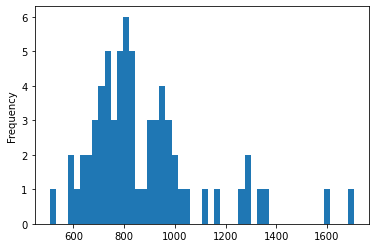

In [51]:
# Plot a histogram of the 2018 Average Monthly Rent

amr_spa['2018 Average Monthly Rent (Euros)'].plot.hist(bins=50)

This graph shows the frequency of neighborhoods in each price range for average monthly rent (2018). It's not super useful, but we can see some outliers on the high end of rent prices. 

In [52]:
amr_spa.head()

c_barri                                n_barri  \
0       22  Vallvidrera, el Tibidabo i les Planes   
1       23                                SarriÃ    
2       25             Sant Gervasi - la Bonanova   
3       43                                  Horta   
4        1                               el Raval   

                                            geometry  \
0  MULTIPOLYGON (((2.07327 41.41383, 2.07165 41.4...   
1  MULTIPOLYGON (((2.12062 41.41357, 2.12065 41.4...   
2  MULTIPOLYGON (((2.13042 41.42065, 2.13049 41.4...   
3  MULTIPOLYGON (((2.16268 41.44105, 2.16273 41.4...   
4  MULTIPOLYGON (((2.17119 41.38659, 2.17180 41.3...   

   2014 Average Monthly Rent (Euros)  2014 Average Monthly Rent (Euros/m^2)  \
0                          1157.9125                                 9.7025   
1                          1039.5050                                13.5175   
2                           940.0200                                11.5575   
3                           567.8525                                 8.9350   
4                           578.4075                                10.4825   

   2015 Average Monthly Rent (Euros)  2015 Average Monthly Rent (Euros/m^2)  \
0                          1030.0475                                12.1975   
1                          1100.4075                                14.4050   
2                          1039.9675                                12.6550   
3                           580.0100                                 9.5725   
4                           624.7375                                10.9975   

   2016 Average Monthly Rent (Euros)  2016 Average Monthly Rent (Euros/m^2)  \
0                          1177.1075                                15.3125   
1                          1188.0025                                15.9475   
2                          1123.6225                                14.2175   
3                           631.1025                                10.6200   
4                           667.3925                                12.2700   

   2017 Average Monthly Rent (Euros)  2017 Average Monthly Rent (Euros/m^2)  \
0                          1231.0100                                16.6600   
1                          1353.5350                                17.4475   
2                          1235.2425                                15.3175   
3                           698.0075                                11.6425   
4                           747.7150                                13.8950   

   2018 Average Monthly Rent (Euros)  2018 Average Monthly Rent (Euros/m^2)  \
0                           939.1125                                12.0675   
1                          1362.0175                                17.1825   
2                          1285.5925                                16.1000   
3                           747.6450                                11.8250   
4                           822.5525                                14.0175   

   2019 Average Monthly Rent (Euros)  2019 Average Monthly Rent (Euros/m^2)  
0                           1200.150                                 13.775  
1                           1369.950                                 16.825  
2                           1303.750                                 16.025  
3                            782.175                                 12.425  
4                            850.900                                 14.325

In [53]:
list(amr_spa)

['c_barri',
 'n_barri',
 'geometry',
 '2014 Average Monthly Rent (Euros)',
 '2014 Average Monthly Rent (Euros/m^2)',
 '2015 Average Monthly Rent (Euros)',
 '2015 Average Monthly Rent (Euros/m^2)',
 '2016 Average Monthly Rent (Euros)',
 '2016 Average Monthly Rent (Euros/m^2)',
 '2017 Average Monthly Rent (Euros)',
 '2017 Average Monthly Rent (Euros/m^2)',
 '2018 Average Monthly Rent (Euros)',
 '2018 Average Monthly Rent (Euros/m^2)',
 '2019 Average Monthly Rent (Euros)',
 '2019 Average Monthly Rent (Euros/m^2)']

In [54]:
# add percent change columns

amr_spa['Percent Change Average Monthly Rent 2014-2015']=round(
    (amr_spa['2015 Average Monthly Rent (Euros)']-amr_spa[
    '2014 Average Monthly Rent (Euros)'])/amr_spa['2014 Average Monthly Rent (Euros)']*100,2)
amr_spa['Percent Change Average Monthly Rent 2015-2016']=round(
    (amr_spa['2016 Average Monthly Rent (Euros)']-amr_spa[
    '2015 Average Monthly Rent (Euros)'])/amr_spa['2015 Average Monthly Rent (Euros)']*100,2)
amr_spa['Percent Change Average Monthly Rent 2016-2017']=round(
    (amr_spa['2017 Average Monthly Rent (Euros)']-amr_spa[
    '2016 Average Monthly Rent (Euros)'])/amr_spa['2016 Average Monthly Rent (Euros)']*100,2)
amr_spa['Percent Change Average Monthly Rent 2017-2018']=round(
    (amr_spa['2018 Average Monthly Rent (Euros)']-amr_spa[
    '2017 Average Monthly Rent (Euros)'])/amr_spa['2017 Average Monthly Rent (Euros)']*100,2)
amr_spa['Percent Change Average Monthly Rent 2018-2019']=round(
    (amr_spa['2019 Average Monthly Rent (Euros)']-amr_spa[
    '2018 Average Monthly Rent (Euros)'])/amr_spa['2018 Average Monthly Rent (Euros)']*100,2)

In [55]:
# include inflation!
inflation = [1.0002, 1.0157, 1.011, 1.0118, 1.0079]

In [56]:
# calculate adjusted monthly rents based on 2014 Euros and inflation
amr_spa['2015 Average Monthly Rent (Euros) - Adjusted']=amr_spa['2015 Average Monthly Rent (Euros)']/inflation[0]
amr_spa['2016 Average Monthly Rent (Euros) - Adjusted']=amr_spa[
    '2016 Average Monthly Rent (Euros)']/(inflation[0]*inflation[1])
amr_spa['2017 Average Monthly Rent (Euros) - Adjusted']=amr_spa[
    '2017 Average Monthly Rent (Euros)']/(inflation[0]*inflation[1]*inflation[2])
amr_spa['2018 Average Monthly Rent (Euros) - Adjusted']=amr_spa[
    '2018 Average Monthly Rent (Euros)']/(inflation[0]*inflation[1]*inflation[2]*inflation[3])
amr_spa['2019 Average Monthly Rent (Euros) - Adjusted']=amr_spa[
    '2019 Average Monthly Rent (Euros)']/(inflation[0]*inflation[1]*inflation[2]*inflation[3]*inflation[4])

amr_spa['2015 Average Monthly Rent (Euros/m^2) - Adjusted']=amr_spa['2015 Average Monthly Rent (Euros/m^2)']/inflation[0]
amr_spa['2016 Average Monthly Rent (Euros/m^2) - Adjusted']=amr_spa[
    '2016 Average Monthly Rent (Euros/m^2)']/(inflation[0]*inflation[1])
amr_spa['2017 Average Monthly Rent (Euros/m^2) - Adjusted']=amr_spa[
    '2017 Average Monthly Rent (Euros/m^2)']/(inflation[0]*inflation[1]*inflation[2])
amr_spa['2018 Average Monthly Rent (Euros/m^2) - Adjusted']=amr_spa[
    '2018 Average Monthly Rent (Euros/m^2)']/(inflation[0]*inflation[1]*inflation[2]*inflation[3])
amr_spa['2019 Average Monthly Rent (Euros/m^2) - Adjusted']=amr_spa[
    '2019 Average Monthly Rent (Euros/m^2)']/(inflation[0]*inflation[1]*inflation[2]*inflation[3]*inflation[4])

In [57]:
# check it 
amr_spa.head()

c_barri                                n_barri  \
0       22  Vallvidrera, el Tibidabo i les Planes   
1       23                                SarriÃ    
2       25             Sant Gervasi - la Bonanova   
3       43                                  Horta   
4        1                               el Raval   

                                            geometry  \
0  MULTIPOLYGON (((2.07327 41.41383, 2.07165 41.4...   
1  MULTIPOLYGON (((2.12062 41.41357, 2.12065 41.4...   
2  MULTIPOLYGON (((2.13042 41.42065, 2.13049 41.4...   
3  MULTIPOLYGON (((2.16268 41.44105, 2.16273 41.4...   
4  MULTIPOLYGON (((2.17119 41.38659, 2.17180 41.3...   

   2014 Average Monthly Rent (Euros)  2014 Average Monthly Rent (Euros/m^2)  \
0                          1157.9125                                 9.7025   
1                          1039.5050                                13.5175   
2                           940.0200                                11.5575   
3                           567.8525                                 8.9350   
4                           578.4075                                10.4825   

   2015 Average Monthly Rent (Euros)  2015 Average Monthly Rent (Euros/m^2)  \
0                          1030.0475                                12.1975   
1                          1100.4075                                14.4050   
2                          1039.9675                                12.6550   
3                           580.0100                                 9.5725   
4                           624.7375                                10.9975   

   2016 Average Monthly Rent (Euros)  2016 Average Monthly Rent (Euros/m^2)  \
0                          1177.1075                                15.3125   
1                          1188.0025                                15.9475   
2                          1123.6225                                14.2175   
3                           631.1025                                10.6200   
4                           667.3925                                12.2700   

   2017 Average Monthly Rent (Euros)  ...  \
0                          1231.0100  ...   
1                          1353.5350  ...   
2                          1235.2425  ...   
3                           698.0075  ...   
4                           747.7150  ...   

   2015 Average Monthly Rent (Euros) - Adjusted  \
0                                   1029.841532   
1                                   1100.187463   
2                                   1039.759548   
3                                    579.894021   
4                                    624.612577   

   2016 Average Monthly Rent (Euros) - Adjusted  \
0                                   1158.680836   
1                                   1169.405284   
2                                   1106.033101   
3                                    621.223102   
4                                    656.945012   

   2017 Average Monthly Rent (Euros) - Adjusted  \
0                                   1198.555427   
1                                   1317.850155   
2                                   1202.676340   
3                                    679.605102   
4                                    728.002105   

   2018 Average Monthly Rent (Euros) - Adjusted  \
0                                    903.690024   
1                                   1310.643429   
2                                   1237.101111   
3                                    719.444505   
4                                    791.526562   

   2019 Average Monthly Rent (Euros) - Adjusted  \
0                                   1145.829373   
1                                   1307.943965   
2                                   1244.740278   
3                                    746.772561   
4                                    812.386963   

   2015 Average Monthly Rent (Euros/m^2) - Adjusted  \
0                                         12.195061   
1     

In [58]:
# Export dataframe to use in other files. 

amr_spa.to_csv (r'Data/barcelona rent data.csv', index = False, header=True)

In [59]:
# Export dataframe as geojson 
amr_spa.to_file('Data/barcelona_rent_data.geojson', driver='GeoJSON')

#### Create a bar chart

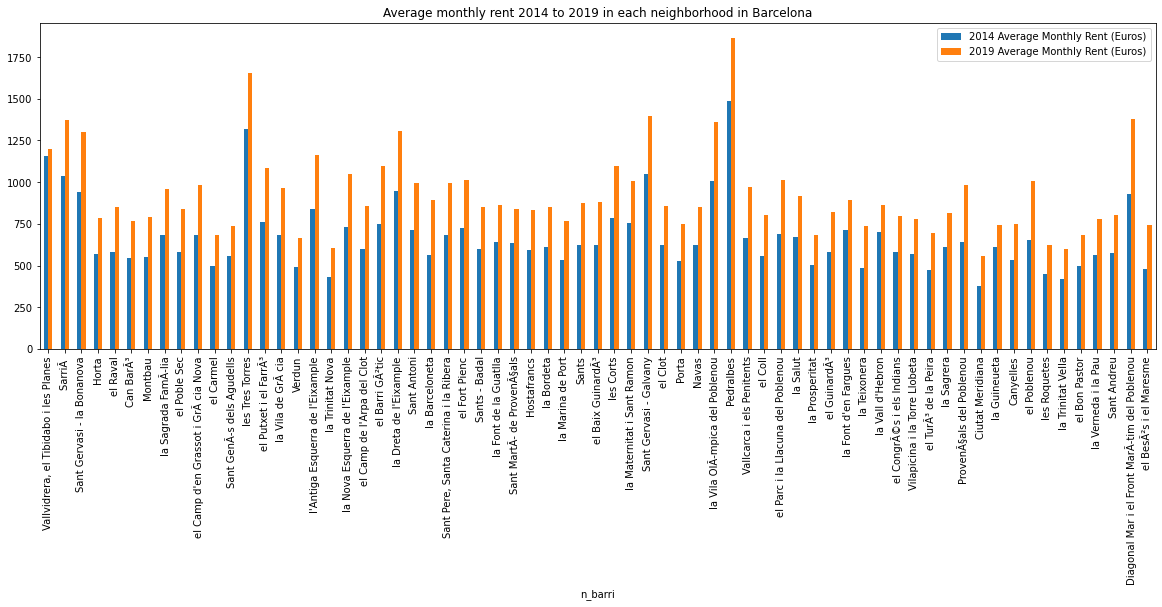

In [60]:
# Print a bar chart with the name of each neighborhood on the x-axis and the 2014-2019 Average Monthly Rent (Euros) on the 
# y axis. 

amr_spa.plot.bar(figsize = (20, 6), 
                  x = 'n_barri', 
                  y = {'2014 Average Monthly Rent (Euros)',
                       '2019 Average Monthly Rent (Euros)'}, 
                  title = 'Average monthly rent 2014 to 2019 in each neighborhood in Barcelona')
plt.savefig('Bar Chart - Average Monthly Rent for Neighborhoods in Barcelona, 2014 to 2019.png',bbox_inches='tight')

The bar graph above depicts rent increases in Barcelona from 2014 to 2019. We can see that rent increased in all neighborhoods, with only Vallvidrera (on the left) remaining approximately the same. 

Now we want to produce a line graph of rent increases in neighborhoods in Barcelona

### Create line graph of rents

In [61]:
# Data manipulation to produce a line graph
amr_data = amr_spa.set_index('n_barri')
amr_data.head()

c_barri  \
n_barri                                          
Vallvidrera, el Tibidabo i les Planes       22   
SarriÃ                                      23   
Sant Gervasi - la Bonanova                  25   
Horta                                       43   
el Raval                                     1   

                                                                                geometry  \
n_barri                                                                                    
Vallvidrera, el Tibidabo i les Planes  MULTIPOLYGON (((2.07327 41.41383, 2.07165 41.4...   
SarriÃ                                 MULTIPOLYGON (((2.12062 41.41357, 2.12065 41.4...   
Sant Gervasi - la Bonanova             MULTIPOLYGON (((2.13042 41.42065, 2.13049 41.4...   
Horta                                  MULTIPOLYGON (((2.16268 41.44105, 2.16273 41.4...   
el Raval                               MULTIPOLYGON (((2.17119 41.38659, 2.17180 41.3...   

                                       2014 Average Monthly Rent (Euros)  \
n_barri                                                                    
Vallvidrera, el Tibidabo i les Planes                          1157.9125   
SarriÃ                                                         1039.5050   
Sant Gervasi - la Bonanova                                      940.0200   
Horta                                                           567.8525   
el Raval                                                        578.4075   

                                       2014 Average Monthly Rent (Euros/m^2)  \
n_barri                                                                        
Vallvidrera, el Tibidabo i les Planes                                 9.7025   
SarriÃ                                                               13.5175   
Sant Gervasi - la Bonanova                                           11.5575   
Horta                                                                 8.9350   
el Raval                                                             10.4825   

                                       2015 Average Monthly Rent (Euros)  \
n_barri                                                                    
Vallvidrera, el Tibidabo i les Planes                          1030.0475   
SarriÃ                                                         1100.4075   
Sant Gervasi - la Bonanova                                     1039.9675   
Horta                                                           580.0100   
el Raval                                                        624.7375   

                                       2015 Average Monthly Rent (Euros/m^2)  \
n_barri                                                                        
Vallvidrera, el Tibidabo i les Planes                                12.1975   
SarriÃ                                                               14.4050   
Sant Gervasi - la Bonanova                                           12.6550   
Horta                                                                 9.5725   
el Raval                                                             10.9975   

                                       2016 Average Monthly Rent (Euros)  \
n_barri                                                                    
Vallvidrera, el Tibidabo i les Planes                          1177.1075   
SarriÃ                                                         1188.0025   
Sant Gervasi - la Bonanova                                     1123.6225   
Horta                                                           631.1025   
el Raval                                                        667.3925   

                                       2016 Average Monthly Rent (Euros/m^2)  \
n_barri                                                                        
Vallvidrera, el Tibidabo i les Planes                                15.3125   
SarriÃ                                                               15.9475   
Sa

In [65]:
# Trim amr_data to only have the columns we want. 
amr_data_tr = amr_data[['2014 Average Monthly Rent (Euros)',
 '2015 Average Monthly Rent (Euros) - Adjusted',
 '2016 Average Monthly Rent (Euros) - Adjusted',
 '2017 Average Monthly Rent (Euros) - Adjusted',
 '2018 Average Monthly Rent (Euros) - Adjusted',
 '2019 Average Monthly Rent (Euros) - Adjusted']]

amr_data_m2_tr = amr_data[[
 '2014 Average Monthly Rent (Euros/m^2)',
 '2015 Average Monthly Rent (Euros/m^2) - Adjusted',
 '2016 Average Monthly Rent (Euros/m^2) - Adjusted',
 '2017 Average Monthly Rent (Euros/m^2) - Adjusted',
 '2018 Average Monthly Rent (Euros/m^2) - Adjusted',
 '2019 Average Monthly Rent (Euros/m^2) - Adjusted']]

In [66]:
# swap axes in order to plot the line graph 
amr_data_swap = amr_data_tr.swapaxes("index", "columns")
amr_data_m2_swap = amr_data_m2_tr.swapaxes("index", "columns")

In [67]:
#Check it
amr_data_swap

n_barri                                       Vallvidrera, el Tibidabo i les Planes  \
2014 Average Monthly Rent (Euros)                                       1157.912500   
2015 Average Monthly Rent (Euros) - Adjusted                            1029.841532   
2016 Average Monthly Rent (Euros) - Adjusted                            1158.680836   
2017 Average Monthly Rent (Euros) - Adjusted                            1198.555427   
2018 Average Monthly Rent (Euros) - Adjusted                             903.690024   
2019 Average Monthly Rent (Euros) - Adjusted                            1145.829373   

n_barri                                           SarriÃ   \
2014 Average Monthly Rent (Euros)             1039.505000   
2015 Average Monthly Rent (Euros) - Adjusted  1100.187463   
2016 Average Monthly Rent (Euros) - Adjusted  1169.405284   
2017 Average Monthly Rent (Euros) - Adjusted  1317.850155   
2018 Average Monthly Rent (Euros) - Adjusted  1310.643429   
2019 Average Monthly Rent (Euros) - Adjusted  1307.943965   

n_barri                                       Sant Gervasi - la Bonanova  \
2014 Average Monthly Rent (Euros)                             940.020000   
2015 Average Monthly Rent (Euros) - Adjusted                 1039.759548   
2016 Average Monthly Rent (Euros) - Adjusted                 1106.033101   
2017 Average Monthly Rent (Euros) - Adjusted                 1202.676340   
2018 Average Monthly Rent (Euros) - Adjusted                 1237.101111   
2019 Average Monthly Rent (Euros) - Adjusted                 1244.740278   

n_barri                                            Horta    el Raval  \
2014 Average Monthly Rent (Euros)             567.852500  578.407500   
2015 Average Monthly Rent (Euros) - Adjusted  579.894021  624.612577   
2016 Average Monthly Rent (Euros) - Adjusted  621.223102  656.945012   
2017 Average Monthly Rent (Euros) - Adjusted  679.605102  728.002105   
2018 Average Monthly Rent (Euros) - Adjusted  719.444505  791.526562   
2019 Average Monthly Rent (Euros) - Adjusted  746.772561  812.386963   

n_barri                                        Can BarÃ³     Montbau  \
2014 Average Monthly Rent (Euros)             543.782500  549.197500   
2015 Average Monthly Rent (Euros) - Adjusted  549.167666  627.554489   
2016 Average Monthly Rent (Euros) - Adjusted  623.169646  631.167456   
2017 Average Monthly Rent (Euros) - Adjusted  666.736071  705.206856   
2018 Average Monthly Rent (Euros) - Adjusted  710.334111  709.376641   
2019 Average Monthly Rent (Euros) - Adjusted  733.740381  757.513369   

n_barri                                       la Sagrada FamÃ­lia  \
2014 Average Monthly Rent (Euros)                      680.387500   
2015 Average Monthly Rent (Euros) - Adjusted           712.207558   
2016 Average Monthly Rent (Euros) - Adjusted           762.378291   
2017 Average Monthly Rent (Euros) - Adjusted           851.641683   
2018 Average Monthly Rent (Euros) - Adjusted           876.178413   
2019 Average Monthly Rent (Euros) - Adjusted           916.262508   

n_barri                                       el Poble Sec  \
2014 Average Monthly Rent (Euros)               582.522500   
2015 Average Monthly Rent (Euros) - Adjusted    611.552689   
2016 Average Monthly Rent (Euros) - Adjusted    658.601173   
2017 Average Monthly Rent (Euros) - Adjusted    728.428070   
2018 Average Monthly Rent (Euros) - Adjusted    771.631404   
2019 Average Monthly Rent (Euros) - Adjusted    799.879889   

n_barri                                       el Camp d'en Grassot i GrÃ cia Nova  \
2014 Average Monthly Rent (Euros)                                      682.210000   
2015 Average Monthly Rent (Euros) - Adjusted                           725.377425   
2016 Average Monthly Rent (Euros) - Adjusted                           790.587181   
2017 Average Monthly Rent (Euros) - Adjusted                           840.785644   
2018 Average Monthly Rent (Euros) - Adjusted                           875.

In [70]:
# produce an interactive line graph of all neighborhoods
fig = px.line(amr_data_swap, 
              color="n_barri", 
              hover_name="n_barri")
fig.show()

That looks great - but let's isolate certain neighborhoods for a closer look.

### Create line graph for Q4 Airbnb counts

We'll query out the data for the neighborhoods in the top quartile of airbnb counts for years 2016-2019. 

In [71]:
# grab only the neighborhoods in Q4 for Airbnb counts (we noted these outside of the notebook and correlated them
# to the c_barri number)
amr_data_sample = amr_data[
    (amr_data['c_barri']==1)|
    (amr_data['c_barri']==2)|
    (amr_data['c_barri']==3)|
    (amr_data['c_barri']==4)|
    (amr_data['c_barri']==5)|
    (amr_data['c_barri']==6)|
    (amr_data['c_barri']==7)|
    (amr_data['c_barri']==8)|
    (amr_data['c_barri']==10)|
    (amr_data['c_barri']==11)|
    (amr_data['c_barri']==15)|
    (amr_data['c_barri']==31)|
    (amr_data['c_barri']==66)|
    (amr_data['c_barri']==67)|
    (amr_data['c_barri']==68)]

In [72]:
#check it
amr_data_sample

c_barri  \
n_barri                                          
el Raval                                     1   
la Sagrada FamÃ­lia                          6   
el Poble Sec                                11   
la Vila de GrÃ cia                          31   
l'Antiga Esquerra de l'Eixample              8   
el Barri GÃ²tic                              2   
la Dreta de l'Eixample                       7   
Sant Antoni                                 10   
la Barceloneta                               3   
Sant Pere, Santa Caterina i la Ribera        4   
el Fort Pienc                                5   
Hostafrancs                                 15   
la Vila OlÃ­mpica del Poblenou              67   
el Parc i la Llacuna del Poblenou           66   
el Poblenou                                 68   

                                                                                geometry  \
n_barri                                                                                    
el Raval                               MULTIPOLYGON (((2.17119 41.38659, 2.17180 41.3...   
la Sagrada FamÃ­lia                    MULTIPOLYGON (((2.18451 41.40716, 2.18564 41.4...   
el Poble Sec                           MULTIPOLYGON (((2.15097 41.37642, 2.15166 41.3...   
la Vila de GrÃ cia                     MULTIPOLYGON (((2.16639 41.40210, 2.16526 41.4...   
l'Antiga Esquerra de l'Eixample        MULTIPOLYGON (((2.16527 41.38743, 2.16526 41.3...   
el Barri GÃ²tic                        MULTIPOLYGON (((2.18361 41.38240, 2.18355 41.3...   
la Dreta de l'Eixample                 MULTIPOLYGON (((2.17447 41.40111, 2.17543 41.4...   
Sant Antoni                            MULTIPOLYGON (((2.16600 41.38704, 2.16520 41.3...   
la Barceloneta                         MULTIPOLYGON (((2.20087 41.38606, 2.20070 41.3...   
Sant Pere, Santa Caterina i la Ribera  MULTIPOLYGON (((2.18354 41.39255, 2.18461 41.3...   
el Fort Pienc                          MULTIPOLYGON (((2.18354 41.39255, 2.18249 41.3...   
Hostafrancs                            MULTIPOLYGON (((2.15022 41.37680, 2.14960 41.3...   
la Vila OlÃ­mpica del Poblenou         MULTIPOLYGON (((2.20745 41.39187, 2.20690 41.3...   
el Parc i la Llacuna del Poblenou      MULTIPOLYGON (((2.19493 41.40614, 2.19722 41.4...   
el Poblenou                            MULTIPOLYGON (((2.21262 41.39594, 2.21242 41.3...   

                                       2014 Average Monthly Rent (Euros)  \
n_barri                                                                    
el Raval                                                        578.4075   
la Sagrada FamÃ­lia                                             680.3875   
el Poble Sec                                                    582.5225   
la Vila de GrÃ cia                                              681.6325   
l'Antiga Esquerra de l'Eixample                                 841.9900   
el Barri GÃ²tic                                                 748.5000   
la Dreta de l'Eixample                                          945.2175   
Sant Antoni                                                     711.3675   
la Barceloneta                                                  563.8125   
Sant Pere, Santa Caterina i la Ribera                           684.2125   
el Fort Pienc                                                   724.5200   
Hostafrancs                                                     593.7650   
la Vila OlÃ­mpica del Poblenou                                 1006.8600   
el Parc i la Llacuna del Poblenou                               689.2400   
el Poblenou                                                     654.5450   

                                       2014 Average Monthly Rent (Euros/m^2)  \
n_barri                                                                        
el Raval                                                             10.4825   
la Sagrada FamÃ­lia                                                  10.4650   
el Poble S

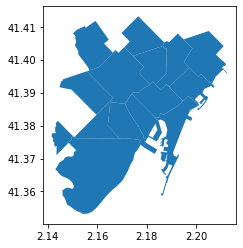

In [73]:
#Check the plot to see if they align with the high airbnb counts in neighborhoods
amr_data_sample.plot()

In [75]:
# trim dataframes 

amr_data_swap_sample = amr_data_swap[[
    'el Raval',
    'el Barri GÃ²tic',
    'la Barceloneta',
    'Sant Pere, Santa Caterina i la Ribera',
    'el Fort Pienc',
    'la Sagrada FamÃ\xadlia',
    "la Dreta de l'Eixample",
    "l'Antiga Esquerra de l'Eixample",
    'Sant Antoni',
    'el Poble Sec',
    'Hostafrancs',
    'la Vila de GrÃ\xa0cia',
    'el Parc i la Llacuna del Poblenou',
    'la Vila OlÃ\xadmpica del Poblenou',
    'el Poblenou'
    ]]

amr_data_m2_swap_sample = amr_data_m2_swap[[
    'el Raval',
    'el Barri GÃ²tic',
    'la Barceloneta',
    'Sant Pere, Santa Caterina i la Ribera',
    'el Fort Pienc',
    'la Sagrada FamÃ\xadlia',
    "la Dreta de l'Eixample",
    "l'Antiga Esquerra de l'Eixample",
    'Sant Antoni',
    'el Poble Sec',
    'Hostafrancs',
    'la Vila de GrÃ\xa0cia',
    'el Parc i la Llacuna del Poblenou',
    'la Vila OlÃ\xadmpica del Poblenou',
    'el Poblenou'
    ]]

In [76]:
# Create a line graph of adjusted rent 
fig = px.line(amr_data_swap_sample,  
              color="n_barri",
              labels={'index':'','value':'Euros'},
              title='2014-2019 Adjusted Rent (Euros) for Neighborhoods with Top Airbnb Total Counts per 1000 Dwellings', 
              hover_name="n_barri")
fig.update_layout(margin={"r":0,"t":35,"l":0,"b":0})
fig.update_layout({
    #'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_html("Output/2014-2019AdjustedRent_Top_Total_Airbnb_per_1000.html")
fig.show()

In [77]:
# Create a line graph of adjusted rent/m2
fig = px.line(amr_data_m2_swap_sample, 
              color="n_barri",
              labels={'index':'','value':'Euros/m^2'},
              title='2014-2019 Adjusted Rent (Euros/m^2) for Neighborhoods with Top Airbnb Total Counts per 1000 Dwellings',
              hover_name="n_barri")
fig.update_layout(margin={"r":0,"t":35,"l":0,"b":0})
fig.update_layout({
    #'plot_bgcolor': 'rgba(0, 0, 0, 0)',
    'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.write_html("Output/2014-2019AdjustedRentm2_Top_Total_Airbnb_per_1000.html")
fig.show()

In [ ]:
#df = px.data.gapminder().query("continent != 'Asia'") # remove Asia for visibility
fig = px.line(amr_data_m2_swap, 
              #x={'2014 Average Monthly Rent (Euros)',
                        #'2015 Average Monthly Rent (Euros)',
                        #'2016 Average Monthly Rent (Euros)',
                        #'2017 Average Monthly Rent (Euros)',
                        #'2018 Average Monthly Rent (Euros)',
                        #'2019 Average Monthly Rent (Euros)'}, 
              #y="n_barri", 
              color="n_barri",
              #line_group="country", 
              hover_name="n_barri")
fig.show()

These charts are helpful. Even with rent priced adjusted, we can still see general increases in rent over the six years. 

### Compare 2018 rental demand and offer price data

We want to compare the demand and offer rental prices for 2018, as well as the 2018 average monthly rent. 

In [78]:
# create dataframe to use for stats
adorp2018_data = adorp2018_spa[['c_barri','n_barri','2018 Average Demand Rental Price (Euros)','2018 Average Offer Rental Price (Euros)','2018 Average Monthly Rent (Euros)']]

In [79]:
# for consistency, we're using the same five barris as the average monthly rent data. This was a challenge. 
adorp2018_data_topbarri = adorp2018_data.loc[(adorp2018_data['n_barri'] == 'Pedralbes') | (adorp2018_data['n_barri'] == 'les Tres Torres') |(adorp2018_data['n_barri'] == 'Sant Gervasi - Galvany')|(adorp2018_data['c_barri'] == 69)|(adorp2018_data['c_barri'] == 23)]

In [80]:
adorp2018_data_topbarri

c_barri                                        n_barri  \
1        23                                        SarriÃ    
12       24                                les Tres Torres   
36       26                         Sant Gervasi - Galvany   
41       21                                      Pedralbes   
64       69  Diagonal Mar i el Front MarÃ­tim del Poblenou   

    2018 Average Demand Rental Price (Euros)  \
1                                    1389.21   
12                                   1667.37   
36                                   1362.47   
41                                   1719.74   
64                                    927.74   

    2018 Average Offer Rental Price (Euros)  2018 Average Monthly Rent (Euros)  
1                                   1875.03                          1362.0175  
12                                  2475.54                          1598.6000  
36                                  2076.07                          1346.9250  
41                                  2611.63                          1707.0125  
64                                  2050.20                          1165.5800

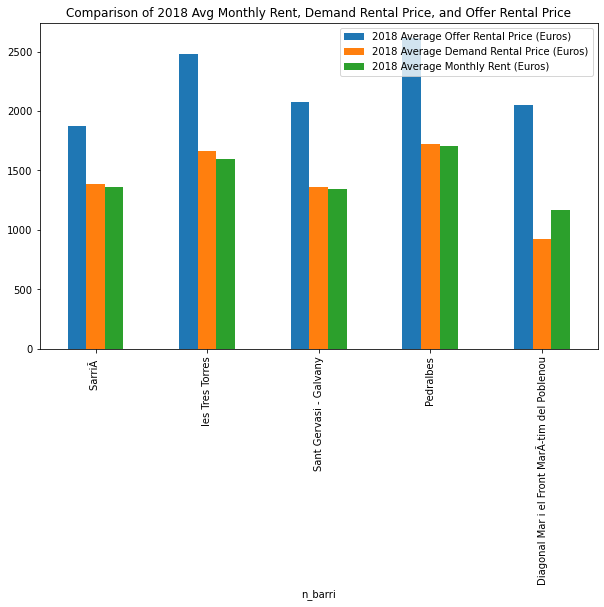

In [81]:
adorp2018_data_topbarri.plot.bar(figsize=(10,6),
                                 title='Comparison of 2018 Avg Monthly Rent, Demand Rental Price, and Offer Rental Price',
                                 x='n_barri',
                                 y={'2018 Average Demand Rental Price (Euros)',
                                    '2018 Average Offer Rental Price (Euros)',
                                    '2018 Average Monthly Rent (Euros)'},
                                rot=90)

plt.savefig('Bar Chart - Comparison of 2018 Average Monthly Rent, Average Demand Rental Price, and Average Offer Rental Price.png',bbox_inches='tight')


This bar chart gives a good comparison of the average rental price offered, average rental price demanded, and the average monthly rent in the top five most expensive neighborhoods. This comparison helps us see the difference between prices being offered and what people are able to pay. 

## Create maps

Try some overall maps with the Average Monthly Rent data. Create sets of subplots side-by-side.

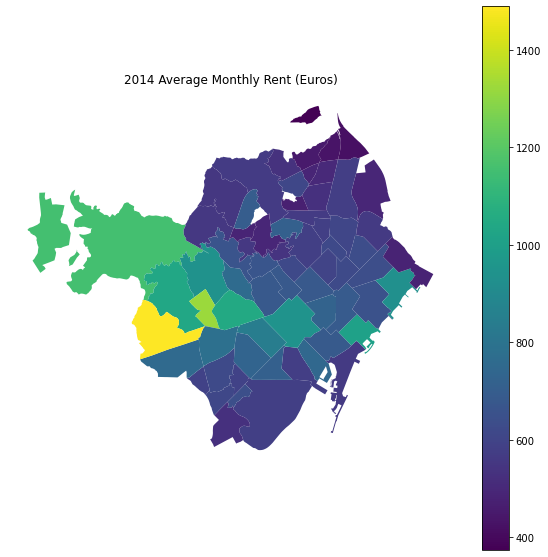

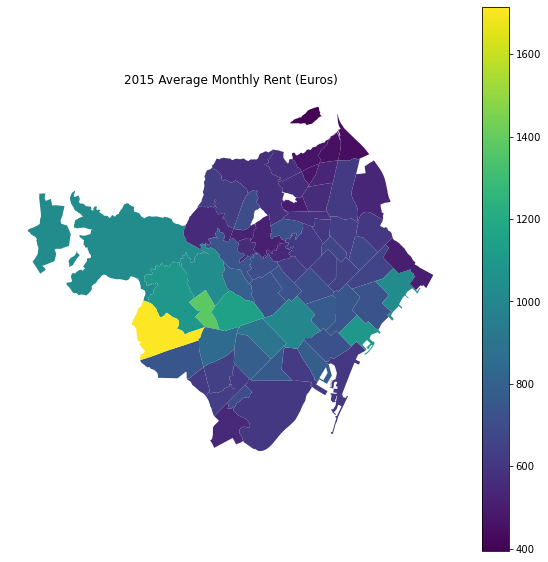

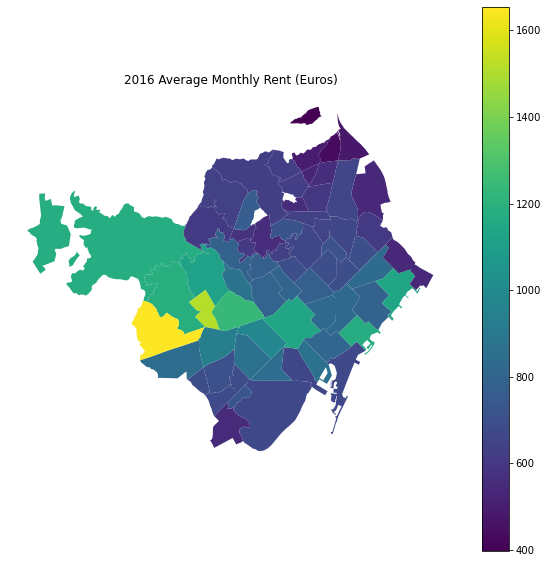

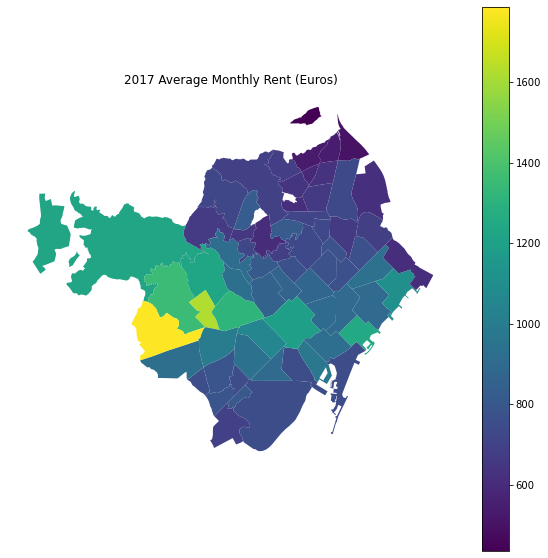

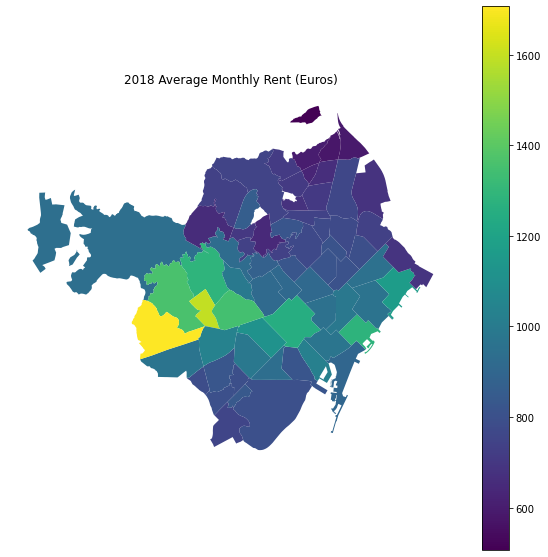

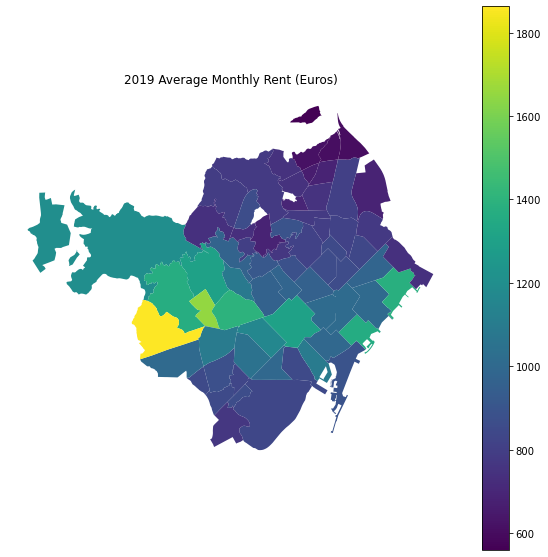

In [82]:
# Test a map! Here's a map of Average Monthly Rent by neighborhood. A beautiful moment, really.
indicators = ['2014 Average Monthly Rent (Euros)',
             '2015 Average Monthly Rent (Euros)',
             '2016 Average Monthly Rent (Euros)',
             '2017 Average Monthly Rent (Euros)',
             '2018 Average Monthly Rent (Euros)',
             '2019 Average Monthly Rent (Euros)',]

for indicator in indicators:
    ax = amr_spa.plot(figsize=(10,10),column=indicator,cmap='viridis',legend=True)
    ax.set_title(indicator)
    ax.axis('off')

In [83]:
bb_n = bb.set_index('n_barri')

In [84]:
# Plot an interactive map of the barris

fig = px.choropleth(bb_n,
                   geojson=bb_n.geometry,                   
                    locations=bb_n.index,
                  color="c_barri",
                    color_continuous_scale="YlOrRd",
                  projection="mercator")
fig.update_geos(fitbounds="locations", visible=False)
fig.write_html("Barri Map.html")
plt.savefig('Barri Map.png',bbox_inches='tight')
fig.show()

<Figure size 432x288 with 0 Axes>

This is cool! But showing a chloropleth by barri doesn't actually tell us anything. And we just have a floating Barcelona. 

In [85]:
bb_n.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [86]:
# Create a map with a mapbox background 

fig = px.choropleth_mapbox(bb_n, geojson=bb_n.geometry, color="c_barri",
                           color_continuous_scale="Viridis",
                           locations=bb_n.index, #featureidkey='n_barri',
                           labels={'n_barri':"Barri "},
                           center={"lat": 41.3851, "lon": 2.1734},
                           mapbox_style="carto-positron", zoom=10)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html("Barri Map with Background.html")
#plt.savefig('Barri Map with Background.png',bbox_inches='tight')
fig.show()

We've added a background! Looks great. Let's get some real data in there. 

In [87]:
# Create a map that shows 2019 Average Monthly rent, and is interactive

# Index the geodataframe by n_barri in order to use the neighborhood names for the interactive labels
amr_spa_n = amr_spa.set_index('n_barri')

fig = px.choropleth_mapbox(amr_spa_n, geojson=amr_spa_n.geometry, color="2019 Average Monthly Rent (Euros)",
                           color_continuous_scale="Greens",
                           locations=amr_spa_n.index, #featureidkey='n_barri',
                           labels={'n_barri':"Barri"},
                           center={"lat": 41.3851, "lon": 2.1734},
                           mapbox_style="carto-positron", zoom=10)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html("2019 Average Monthly Rent (Euros) Map.html")
fig.show()

In [88]:
# Create a map that shows 2019 Average Monthly rent, and is interactive

# Index the geodataframe by n_barri in order to use the neighborhood names for the interactive labels
amr_spa_n = amr_spa.set_index('n_barri')

fig = px.choropleth_mapbox(amr_spa_n, geojson=amr_spa_n.geometry, color="2019 Average Monthly Rent (Euros)",
                           color_continuous_scale="Oranges",
                           locations=amr_spa_n.index, #featureidkey='n_barri',
                           labels={'n_barri':"Barri"},
                           center={"lat": 41.3851, "lon": 2.1734},
                           opacity=0.7,
                           mapbox_style="carto-positron", zoom=10)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html("2019 Average Monthly Rent (Euros) Map_Orange.html")
fig.show()

Now that is a map. We've lost some of the barris based on removing the null data earlier. This map gives a good depiction of average monthly rents across the city though, with a cluster of western neighborhoods that have higher rent prices, and neighborhoods to the north with lower rent prices.

It will be interesting to compare this to housing scarcity data (tourist housing, empty dwellings, housing in poor condition). 

### Create subplots to compare multiple data

We've learned how to compare subplots at the same legend "bins", so we've implemented that here. 

Text(0.5, 1.0, '2018 Average Offer Rental Price in Barcelona')

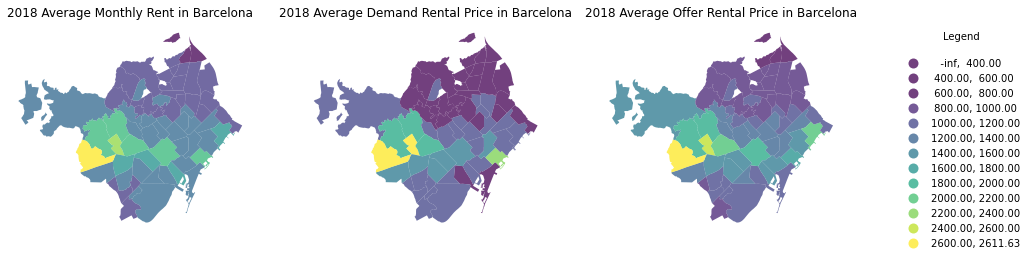

In [89]:
# Create subplots: one row, two plots

fig, axs = plt.subplots(1, 3, figsize=(15, 12))

# name each subplot
ax1, ax2, ax3 = axs

# Left map
adorp2018_spa.plot(column = '2018 Average Monthly Rent (Euros)', 
            cmap = 'viridis', # Is there a reason this color looks faded (and better) in these subplots?
            scheme='user_defined', 
            classification_kwds={'bins':[400,600,800,1000,1200,1400,1600,1800,2000,2200,2400,2600]},
            #k = 5, # five buckets 
            edgecolor = 'white', 
            linewidth = 0., 
            alpha = 0.75, 
            ax = ax1, # this assigns the map to the subplot,
            legend = False)
            #legend_kwds={'orientation': "horizontal"})
           

ax1.axis("off") # turns off x and y axis numbers 
ax1.set_title("2018 Average Monthly Rent in Barcelona") # add a title to ax1


# Middle map
adorp2018_spa.plot(column = '2018 Average Demand Rental Price (Euros)', 
            cmap = 'viridis', 
            scheme='user_defined', 
            classification_kwds={'bins':[400,600,800,1000,1200,1400,1600,1800,2000,2200,2400,2600]}, 
            edgecolor = 'white', 
            linewidth = 0., 
            alpha = 0.75, 
            ax = ax2, # this assigns the map to the subplot
            legend = False)
                 # legend_kwds={'orientation': "horizontal"})

ax2.axis("off")
ax2.set_title("2018 Average Demand Rental Price in Barcelona")

# Right map
adorp2018_spa.plot(column = '2018 Average Offer Rental Price (Euros)', 
            cmap = 'viridis', 
            scheme='user_defined', 
            classification_kwds={'bins':[400,600,800,1000,1200,1400,1600,1800,2000,2200,2400,2600]},
            edgecolor = 'white', 
            linewidth = 0., 
            alpha = 0.75, 
            ax = ax3, # this assigns the map to the subplot
            legend = True,
            legend_kwds={'loc':"upper right", 'bbox_to_anchor':(1.75, 1.0), 'title':"Legend\n", 'frameon':False})

ax3.axis("off")
ax3.set_title("2018 Average Offer Rental Price in Barcelona")

These maps give a visual spatial comparison between 2018 average monthly rent, 2018 average demand rental price, and 2018 average offer rental price. It's a bit difficult to see the differences in a chloropleth map, so we may just stick with the bar graphs. But still an interesting comparison. 

Also - pretty proud of this legend action over here --> 
Just need to figure out how to set a lower bound at zero. <-- turns out the legend is not representative of all three maps! need to set vmin, vmax. 

Text(0.5, 1.0, 'Average 2019 Monthly Rent in Barcelona')

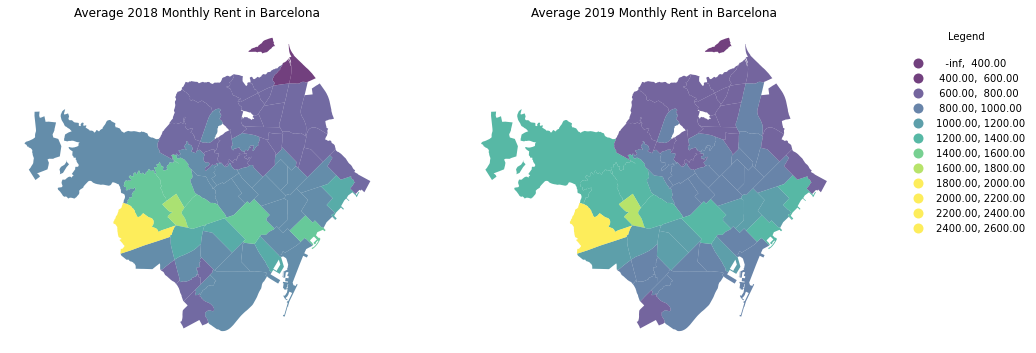

In [94]:
# Create subplots: one row, two plots

fig, axs = plt.subplots(1, 2, figsize=(15, 12))

# name each subplot
ax1, ax2 = axs

# Left map
amr_spa.plot(column = '2018 Average Monthly Rent (Euros)', 
            cmap = 'viridis', # Is there a reason this color looks faded (and better) in these subplots?
            scheme='user_defined', 
            classification_kwds={'bins':[400,600,800,1000,1200,1400,1600,1800,2000,2200,2400,2600]}, 
            edgecolor = 'white', 
            linewidth = 0., 
            alpha = 0.75, 
            ax = ax1, # this assigns the map to the subplot,
            legend = False)
           

ax1.axis("off") # turns off x and y axis numbers 
ax1.set_title("Average 2018 Monthly Rent in Barcelona") # add a title to ax1

# Right map
amr_spa.plot(column = '2019 Average Monthly Rent (Euros)', 
            cmap = 'viridis', 
            scheme='user_defined', 
            classification_kwds={'bins':[400,600,800,1000,1200,1400,1600,1800,2000,2200,2400,2600]},
            edgecolor = 'white', 
            linewidth = 0., 
            alpha = 0.75, 
            ax = ax2, # this assigns the map to the subplot
            legend = True,
            legend_kwds={'loc':"upper right", 'bbox_to_anchor':(1.5, 1.0), 'title':"Legend\n", 'frameon':False})

ax2.axis("off")
ax2.set_title("Average 2019 Monthly Rent in Barcelona")

These maps show slight differences in the rental prices between 2018 and 2019. It will be interesting to compare the percent increases in rental prices and whether certain neighborhoods are increasing at a higher rate. We'd also like to compare these maps with maps of tourist dwellings. 

Note: discovered later that this legend for two plots doesn't work. we need to set vmin and vmax. 

### End of file

This notebook file is an updated + clean version of our midterm assignment. 

We have a separate file that includes functions and loops to clean up population data in Barcelona. 

Division of Work: We worked together to work through creating functions and using for loops to clean our data more efficiently. Tiffany created the population data notebook, which cleans the Barcelona population data file and outputs a clean version to be used in other notebooks. I updated this notebook from our midterm assignment, cleaned up the processes, and edited some of the subplot maps. We shared responsiblity in researching and learning how to properly use functions and loops. 